<a href="https://colab.research.google.com/github/davidlcarr/HadoopJupyter2023/blob/main/ProjetoFase2_SILOMS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 📌 1. Importação de bibliotecas
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from openpyxl import load_workbook
from openpyxl.styles import PatternFill
from fpdf import FPDF


In [12]:
# 📌 2. Carregamento e preparação dos dados
# Faça upload do arquivo .xlsx manualmente no Colab
from google.colab import files
uploaded = files.upload()

Saving RelGestorFin.xlsx to RelGestorFin.xlsx


In [13]:
# 📌 Substitua pelo nome correto, se necessário
df = pd.read_excel("RelGestorFin.xlsx", skiprows=1)

# 📌 Renomear colunas
df.columns = [
    "nota_fiscal", "status", "empresa", "data_emissao", "data_entrada", "ug_cred", "ug_pagadora",
    "ug_atual", "situacao_atual", "data_situacao", "dias_na_situacao", "np", "ne", "nd",
    "ptres", "fonte_recurso", "valor_fat_emp", "valor_total_nf"
]

# 📌 Remover colunas desnecessárias
colunas_excluir = [
    "status", "ug_cred", "ug_pagadora", "ug_atual",
    "data_situacao", "np", "ptres", "fonte_recurso", "valor_fat_emp", "ne", "nd"
]
df.drop(columns=colunas_excluir, inplace=True)

# 📌 Ajustar a coluna "empresa"
# Remove tudo que vem antes e incluindo '|', e mantém só a primeira palavra
df["empresa"] = df["empresa"].astype(str).str.split("|").str[-1].str.strip()
df["empresa"] = df["empresa"].str.split().str[0]

# 📌 Conversão de datas
#df["data_emissao"] = pd.to_datetime(df["data_emissao"], errors="coerce")
#df["data_entrada"] = pd.to_datetime(df["data_entrada"], errors="coerce")

# 📌 Formatando datas no padrão brasileiro (dd/mm/aaaa)
df["data_emissao"] = df["data_emissao"].dt.strftime("%d/%m/%Y")
df["data_entrada"] = df["data_entrada"].dt.strftime("%d/%m/%Y")


In [22]:
# 📌 Converter datas
df["data_emissao"] = pd.to_datetime(df["data_emissao"], errors="coerce")

# 📌 Calcular vencimento (30 dias após emissão)
df["data_vencimento"] = df["data_emissao"] + pd.Timedelta(days=30)

# 📌 Calcular dias até o vencimento
hoje = pd.to_datetime(datetime.today().date())
df["dias_ate_vencimento"] = (df["data_vencimento"] - hoje).dt.days

# 📌 Adicionar status de vencimento
df["status_vencimento"] = df["dias_ate_vencimento"].apply(lambda x: "Atrasada" if x < 0 else "Em dia")

# 📌 Formatar texto do vencimento
def formatar_vencimento(dias):
    if pd.isna(dias):
        return "Data inválida"
    elif dias > 0:
        return f"{dias} dias até o venc."
    elif dias == 0:
        return "Vence hoje"
    else:
        return f"{abs(dias)} dias após o venc."

df["dias_ate_vencimento"] = df["dias_ate_vencimento"].apply(formatar_vencimento)

# 📌 Formatar a data no padrão brasileiro
df["data_emissao"] = df["data_emissao"].dt.strftime("%d/%m/%Y")

# 📌 Selecionar colunas na ordem desejada
final = df[[
    "nota_fiscal", "empresa", "data_emissao", "status_vencimento",
    "dias_ate_vencimento"
]]

final

,nota_fiscal,empresa,data_emissao,status_vencimento,dias_ate_vencimento
0,SVP001068951,ELETROPAULO,03/06/2025,Em dia,14 dias até o venc.
1,SVP001068951,ELETROPAULO,03/06/2025,Em dia,14 dias até o venc.
2,SVP717409519,ELETROPAULO,05/06/2025,Em dia,16 dias até o venc.
3,SVP719056942,ELETROPAULO,10/06/2025,Em dia,21 dias até o venc.
4,SVP716547393,ELETROPAULO,03/04/2025,Atrasada,47 dias após o venc.
5,SVP001066524,ELETROPAULO,03/05/2025,Atrasada,17 dias após o venc.
6,SVP716996448,ELETROPAULO,04/06/2025,Em dia,15 dias até o venc.
7,SVP168505376,COMPANHIA,09/05/2025,Atrasada,11 dias após o venc.
8,SVP168505376,COMPANHIA,09/04/2025,Atrasada,41 dias após o venc.
9,INSS371,ENGETORRES,04/06/2025,Em dia,15 dias até o venc.


In [15]:
# 📌 Caminho para salvar o Excel
excel_path = "Resumo_Vencimentos.xlsx"

# 📌 Exportar para Excel
final.to_excel(excel_path, index=False)

# 📌 Aplicar formatação no Excel com openpyxl
wb = load_workbook(excel_path)
ws = wb.active
vermelho = PatternFill(start_color="FFC7CE", end_color="FFC7CE", fill_type="solid")

# Percorrer linhas e pintar as que estiverem com status "Atrasada"
for row in range(2, ws.max_row + 1):
    if ws[f"D{row}"].value == "Atrasada":
        for col in range(1, ws.max_column + 1):
            ws.cell(row=row, column=col).fill = vermelho

wb.save(excel_path)
wb.close()

# 📌 Gerar PDF com os 20 primeiros registros da tabela "final"
pdf = FPDF()
pdf.add_page()
pdf.set_font("Arial", size=10)
pdf.cell(200, 10, txt="Resumo de Notas Fiscais e Vencimentos", ln=1, align="C")
pdf.ln(5)

# Cabeçalhos
headers = ["Nota Fiscal", "Empresa", "Data Emissão", "Status", "Descrição"]
col_widths = [30, 30, 30, 30, 70]

for i, header in enumerate(headers):
    pdf.cell(col_widths[i], 10, header, border=1)
pdf.ln()

# Adicionar os dados (máximo 20 linhas)
for _, row in final.head(20).iterrows():
    pdf.cell(col_widths[0], 10, str(row["nota_fiscal"]), border=1)
    pdf.cell(col_widths[1], 10, str(row["empresa"]), border=1)
    pdf.cell(col_widths[2], 10, str(row["data_emissao"]), border=1)
    pdf.cell(col_widths[3], 10, str(row["status_vencimento"]), border=1)
    pdf.cell(col_widths[4], 10, str(row["dias_ate_vencimento"])[:40], border=1)
    pdf.ln()

# 📌 Salvar o PDF
pdf.output("Resumo_Vencimentos.pdf")

''

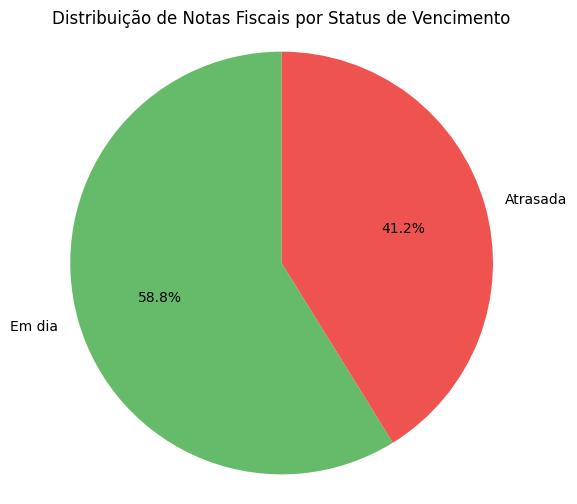

/tmp/ipython-input-19-1094880422.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final["dias_ate_vencimento_num"] = final["dias_ate_vencimento"].apply(extrair_dias)


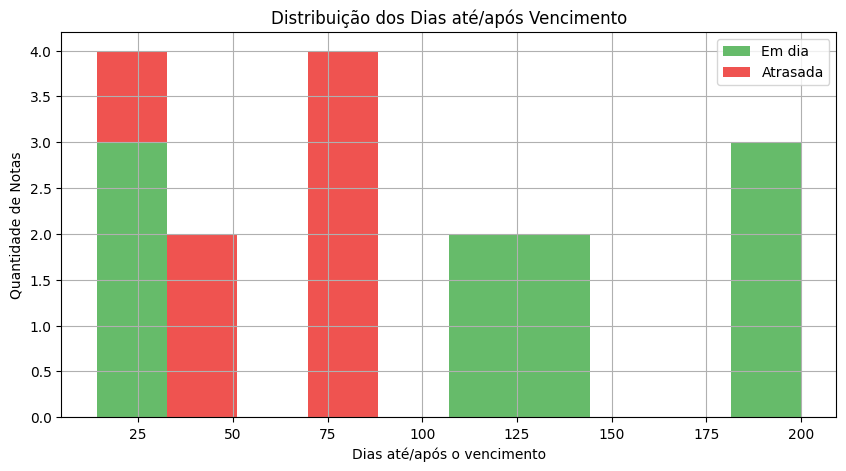

In [19]:
# Contagem de status
total = len(final)
atrasadas = len(final[final["status_vencimento"] == "Atrasada"])
em_dia = total - atrasadas

# Gráfico de pizza: proporção de notas
labels = ['Em dia', 'Atrasada']
sizes = [em_dia, atrasadas]
colors = ['#66bb6a', '#ef5350']

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Distribuição de Notas Fiscais por Status de Vencimento')
plt.axis('equal')
plt.show()

# Conversão dos textos da coluna "dias_ate_vencimento" em números
def extrair_dias(valor):
    try:
        return int(valor.split(" ")[0])
    except:
        return None

final["dias_ate_vencimento_num"] = final["dias_ate_vencimento"].apply(extrair_dias)

# Separar listas para gráfico de barras
dias_atrasadas = final[final["status_vencimento"] == "Atrasada"]["dias_ate_vencimento_num"].dropna().tolist()
dias_em_dia = final[final["status_vencimento"] == "Em dia"]["dias_ate_vencimento_num"].dropna().tolist()

# Gráfico de barras: distribuição de dias
plt.figure(figsize=(10, 5))
plt.hist([dias_em_dia, dias_atrasadas], bins=10, label=['Em dia', 'Atrasada'],
         color=['#66bb6a', '#ef5350'], stacked=True)
plt.xlabel('Dias até/após o vencimento')
plt.ylabel('Quantidade de Notas')
plt.title('Distribuição dos Dias até/após Vencimento')
plt.legend()
plt.grid(True)
plt.show()